In [1]:
from __future__ import division
import numpy as np
import scipy
from sklearn.base import BaseEstimator
import pickle
import os
import gzip
import phate 
import scprep
from sklearn import datasets
import matplotlib.pyplot as plt

from kernel_triplet import *

In [6]:
#Load data 
digits = datasets.load_digits()

X_train = digits.data[500:] / 16
X_test = digits.data[:500] / 16
y_train = digits.target[500:]
y_test = digits.target[:500]

In [7]:
#Using the model by fitting the train set
model = KernelTriplet(n_iter=100000, make_pos_sd=True, psd_every=3, save_path="/Users/arijitsehanobish/").fit(X_train, y_train)

In [8]:
#prediction via KNN as in the original paper 
errrate = model.predict(X_test, X_train, y_test, y_train, maxk=1000)
print ("Min error rate: %6.4f at k=%d" \
          % (min(errrate), np.argmin(errrate) + 1))


Min error rate: 0.0580 at k=30


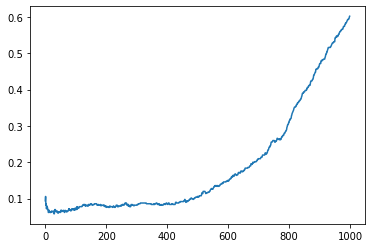

In [9]:
plt.figure()
plt.plot(errrate)

In [10]:
model._weights == model._weights.T #seems like there is a bug. The weights is guaranteed to be symmetric 

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ...,
       [ True, False, False, ...,  True,  True, False],
       [ True, False, False, ...,  True,  True, False],
       [ True, False, False, ..., False, False,  True]])

In [11]:
#anyways symmetrize the matrix 
w_sym = pos_semidefinite(model._weights)

In [12]:
w_sym == w_sym.T #bugs due to floating point issues. Did not see the similar thing in matlab :(

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ..., False, False, False],
       [ True, False,  True, ...,  True, False, False],
       ...,
       [ True, False,  True, ...,  True,  True, False],
       [ True, False, False, ...,  True,  True,  True],
       [ True, False, False, ..., False,  True,  True]])

In [25]:
#TODO Fix this numerical instability in these eigenvalues and eigenvectors

In [13]:
#Get the affinity matrix 
s = np.dot(X_test, np.dot(w_sym, X_test.T))

In [14]:
phate_operator = phate.PHATE(n_jobs=-2, knn_dist='precomputed')

In [15]:
np.min(s)

-6.822701380828777

In [16]:
np.max(s)

12.664394986115328

In [17]:
s_rangescale = (s - np.min(s))/(np.max(s)-np.min(s))

In [18]:
phate_operator = phate.PHATE(n_jobs=-2, knn_dist='precomputed')

In [19]:
new = phate_operator.fit_transform(s_rangescale)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 500 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 2
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.20 seconds.
Calculated PHATE in 0.27 seconds.


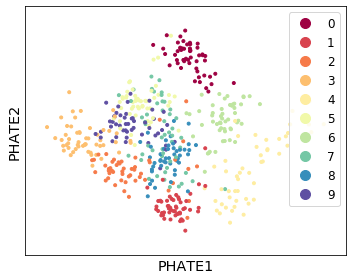

In [21]:
scprep.plot.scatter2d(new, c=y_test, figsize=(5,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [22]:
#transforming data to the W-space
new_data = np.dot(X_test, w_sym) 

In [23]:
phate_operator_default = phate.PHATE(n_jobs=-2)
new1 = phate_operator_default.fit_transform(new_data)

Calculating PHATE...
  Running PHATE on 500 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.20 seconds.
Calculated PHATE in 0.41 seconds.


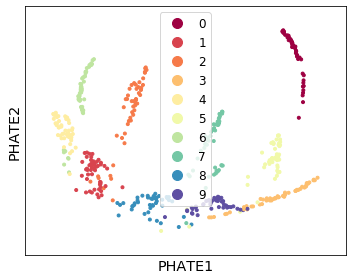

In [24]:
scprep.plot.scatter2d(new1, c=y_test, figsize=(5,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")